**Center for Microfinance Dataset**

A dataset on microfinance from The Centre for Micro Finance (CMF) at the Institute for Financial Management Research (Chennai, India).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Exploration-Data" data-toc-modified-id="Exploration-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exploration Data</a></span></li><li><span><a href="#Modeling-Data" data-toc-modified-id="Modeling-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modeling Data</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Full-Data-Visualization" data-toc-modified-id="Full-Data-Visualization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Full Data Visualization</a></span></li><li><span><a href="#Modeling-Data-Preparation" data-toc-modified-id="Modeling-Data-Preparation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modeling Data Preparation</a></span></li></ul></li><li><span><a href="#Standard-Models" data-toc-modified-id="Standard-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standard Models</a></span><ul class="toc-item"><li><span><a href="#Two-Model" data-toc-modified-id="Two-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Two Model</a></span></li><li><span><a href="#Interaction-Term" data-toc-modified-id="Interaction-Term-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Interaction Term</a></span></li><li><span><a href="#Class-Transformations" data-toc-modified-id="Class-Transformations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Class Transformations</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Iterations" data-toc-modified-id="Iterations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Iterations</a></span></li><li><span><a href="#Visual" data-toc-modified-id="Visual-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visual</a></span></li><li><span><a href="#Iterated-Evaluation-and-Variance" data-toc-modified-id="Iterated-Evaluation-and-Variance-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Iterated Evaluation and Variance</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [12]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from causeinfer.data import cmf_micro
from causeinfer.utils import plot_unit_distributions, train_test_split, over_sample
from causeinfer.standard_algorithms import TwoModel, InteractionTerm
from causeinfer.evaluation import qini_score, auuc_score
from causeinfer.evaluation import plot_cum_effect, plot_cum_gain, plot_qini
from causeinfer.evaluation import plot_batch_responses, signal_to_noise
from causeinfer.evaluation import iterate_model, eval_table

pd.set_option("display.max_rows", 16)
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# Load Data

In [13]:
# Deprecated - see: https://github.com/andrewtavis/causeinfer/tree/master/causeinfer/data/datasets
# cmf_micro.download_cmf_micro() 

## Exploration Data

In [14]:
# The full mostly unformatted dataset is loaded
data_raw = cmf_micro.load_cmf_micro(user_file_path="datasets/cmf_micro",
                                     format_covariates=False, 
                                     normalize=False)

df_full = pd.DataFrame(data_raw["dataset_full"], 
                       columns=data_raw["dataset_full_names"])

display(df_full.head())
df_full.shape

,treatment,area_id,w,w1,w2,sample1,sample2,old_biz,any_old_biz,area_pop_base,area_debt_total_base,area_business_total_base,area_exp_pc_mean_base,area_literate_head_base,area_literate_base,visitday_1,visitmonth_1,visityear_1,visitday_2,visitmonth_2,visityear_2,hhsize_1,hhsize_adj_1,adults_1,children_1,male_head_1,head_age_1,head_noeduc_1,women1845_1,anychild1318_1,hhsize_2,hhsize_adj_2,adults_2,children_2,male_head_2,head_age_2,head_noeduc_2,women1845_2,anychild1318_2,spouse_literate_1,spouse_works_wage_1,ownland_hyderabad_1,ownland_village_1,spouse_literate_2,spouse_works_wage_2,ownland_hyderabad_2,ownland_village_2,spandana_1,othermfi_1,anymfi_1,anybank_1,anyinformal_1,anyloan_1,everlate_1,mfi_loan_cycles_1,spandana_amt_1,othermfi_amt_1,anymfi_amt_1,bank_amt_1,informal_amt_1,anyloan_amt_1,spandana_2,othermfi_2,anymfi_2,anybank_2,anyinformal_2,anyloan_2,everlate_2,mfi_loan_cycles_2,spandana_amt_2,othermfi_amt_2,anymfi_amt_2,bank_amt_2,informal_amt_2,anyloan_amt_2,bizassets_1,bizinvestment_1,bizrev_1,bizexpense_1,bizprofit_1,bizemployees_1,any_biz_1,total_biz_1,any_new_biz_1,biz_stop_1,newbiz_1,female_biz_1,female_biz_new_1,bizassets_2,bizinvestment_2,bizrev_2,bizexpense_2,bizprofit_2,bizemployees_2,any_biz_2,total_biz_2,any_new_biz_2,biz_stop_2,newbiz_2,female_biz_2,female_biz_new_2,wages_nonbiz_1,wages_nonbiz_2,hours_week_1,hours_week_biz_1,hours_week_outside_1,hours_headspouse_week_1,hours_headspouse_outside_1,hours_headspouse_biz_1,hours_child1620_week_1,hours_girl1620_week_1,hours_boy1620_week_1,hours_week_2,hours_week_biz_2,hours_week_outside_2,hours_headspouse_week_2,hours_headspouse_outside_2,hours_headspouse_biz_2,hours_child1620_week_2,hours_girl1620_week_2,hours_boy1620_week_2,total_exp_mo_1,durables_exp_mo_1,nondurable_exp_mo_1,health_exp_mo_1,educ_exp_mo_1,festival_exp_annual_1,temptation_exp_mo_1,food_exp_mo_1,total_exp_mo_pc_1,durables_exp_mo_pc_1,nondurable_exp_mo_pc_1,food_exp_mo_pc_1,health_exp_mo_pc_1,educ_exp_mo_pc_1,temptation_exp_mo_pc_1,festival_exp_mo_pc_1,home_durable_index_1,total_exp_mo_2,durables_exp_mo_2,nondurable_exp_mo_2,health_exp_mo_2,educ_exp_mo_2,festival_exp_annual_2,temptation_exp_mo_2,food_exp_mo_2,total_exp_mo_pc_2,durables_exp_mo_pc_2,nondurable_exp_mo_pc_2,food_exp_mo_pc_2,health_exp_mo_pc_2,educ_exp_mo_pc_2,temptation_exp_mo_pc_2,festival_exp_mo_pc_2,home_durable_index_2,girl515_school_1,boy515_school_1,girl515_workhrs_pc_1,boy515_workhrs_pc_1,girl1620_school_1,boy1620_school_1,female_biz_pct_1,girl515_school_2,boy515_school_2,girl515_workhrs_pc_2,boy515_workhrs_pc_2,girl1620_school_2,boy1620_school_2,women_emp_index_2,female_biz_pct_2,credit_index_1,biz_index_old_1,biz_index_new_1,income_index_1,labor_index_1,consumption_index_1,social_index_1,credit_index_2,biz_index_all_2,biz_index_old_2,income_index_2,labor_index_2,consumption_index_2,women_emp_index_1,biz_index_all_1,social_index_2
0,1.0,1.0,0.819672,0.777092,0.819672,1.0,1.0,0.0,0.0,272.0,81050.0,11.0,1334.766113,0.5,0.533898,22.0,8.0,2007.0,16.0,12.0,2009.0,3.0,2.80,3.0,0.0,1.0,20.0,1.0,2.0,0.0,3.0,2.42,2.0,1.0,1.0,32.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,18000.0,0.0,18000.0,0.0,93540.0,115780.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,0.000000,11000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,7000.0,48.0,0.0,48.0,48.0,48.0,0.0,48.0,0.0,48.0,84.0,0.0,84.0,84.0,84.0,0.0,NaN,NaN,NaN,2154.000000,NaN,NaN,250.000000,NaN,600.0,170.0,1084.0,769.285706,NaN,NaN,387.142853,89.285713,NaN,60.714287,17.857143,2.693964,4128.382324,138.829819,3989.552734,63.167572,763.564026,1665.957857,0.000000,2372.0,1705.943115,57.367695,1648.575439,980.165283,26.102303,315.522308,0.000000,57.367695,2.677674,NaN,NaN,NaN,NaN,0.0,1.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,-0.428467,NaN,1.135847,NaN,NaN,-0.160999,-0.104168,-0.166209,-0.078313,-0.420189,-0.319804,NaN,0.089781,0.220555,-0.156785,-0.415386,-0.223974,-0.058573
1,1.0,1.0,1.00

(6863, 186)

## Modeling Data

In [15]:
# The formatted dataset is loaded
data_cmf_micro = cmf_micro.load_cmf_micro(user_file_path="datasets/cmf_micro",
                                          format_covariates=True, 
                                          normalize=True)

df = pd.DataFrame(data_cmf_micro["dataset_full"], 
                  columns=data_cmf_micro["dataset_full_names"])

In [16]:
# Covariates, treatments and responses are loaded separately
X = data_cmf_micro["features"]

y = data_cmf_micro["response_biz_index"] # response_biz_index or response_women_emp

w = data_cmf_micro["treatment"]

# Data Exploration

In [17]:
sns.set(style="whitegrid")

## Full Data Visualization

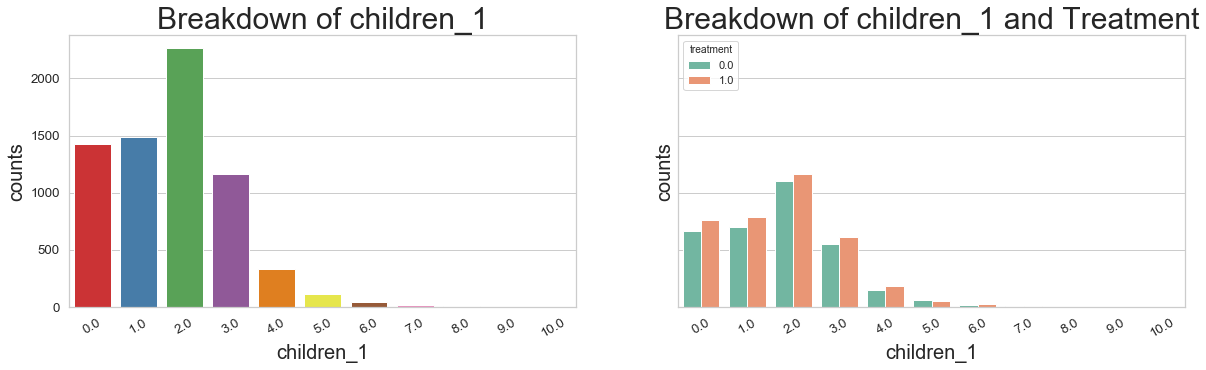

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

plot_unit_distributions(df=df_full, variable='children_1', treatment = None,
                        plot_x_label='children_1', plot_y_label='counts', plot_title='Breakdown of children_1', 
                        bins=None, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='children_1', treatment = 'treatment',
                        plot_x_label='children_1', plot_y_label='counts', plot_title='Breakdown of children_1 and Treatment', 
                        bins=None, figsize=None, fontsize=20, axis=ax2)

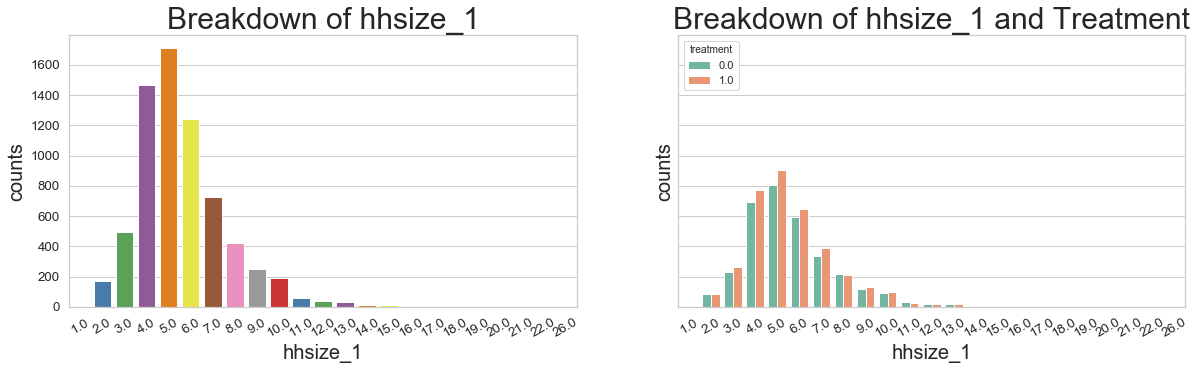

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

plot_unit_distributions(df=df_full, variable='hhsize_1', treatment = None,
                        plot_x_label='hhsize_1', plot_y_label='counts', plot_title='Breakdown of hhsize_1', 
                        bins=None, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='hhsize_1', treatment = 'treatment',
                        plot_x_label='hhsize_1', plot_y_label='counts', plot_title='Breakdown of hhsize_1 and Treatment', 
                        bins=None, figsize=None, fontsize=20, axis=ax2)

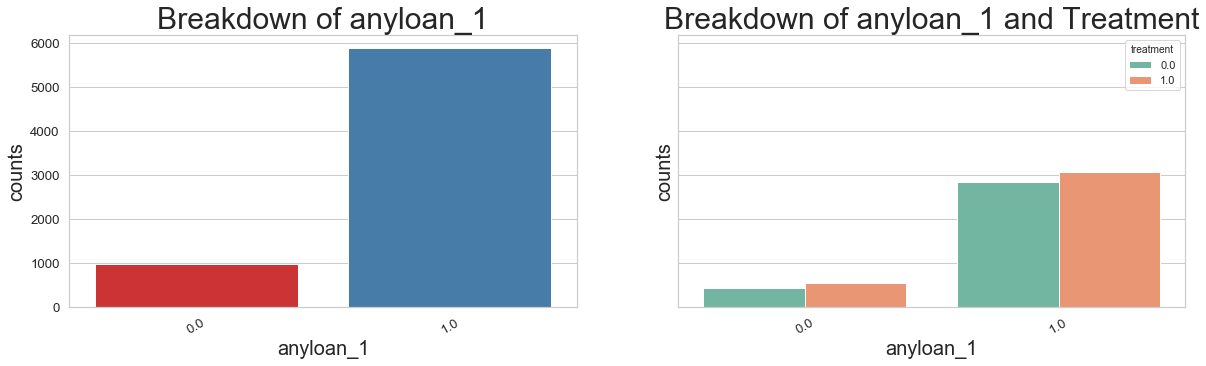

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

plot_unit_distributions(df=df_full, variable='anyloan_1', treatment = None,
                        plot_x_label='anyloan_1', plot_y_label='counts', plot_title='Breakdown of anyloan_1', 
                        bins=None, figsize=None, fontsize=20, axis=ax1),

plot_unit_distributions(df=df_full, variable='anyloan_1', treatment = 'treatment',
                        plot_x_label='anyloan_1', plot_y_label='counts', plot_title='Breakdown of anyloan_1 and Treatment', 
                        bins=None, figsize=None, fontsize=20, axis=ax2)

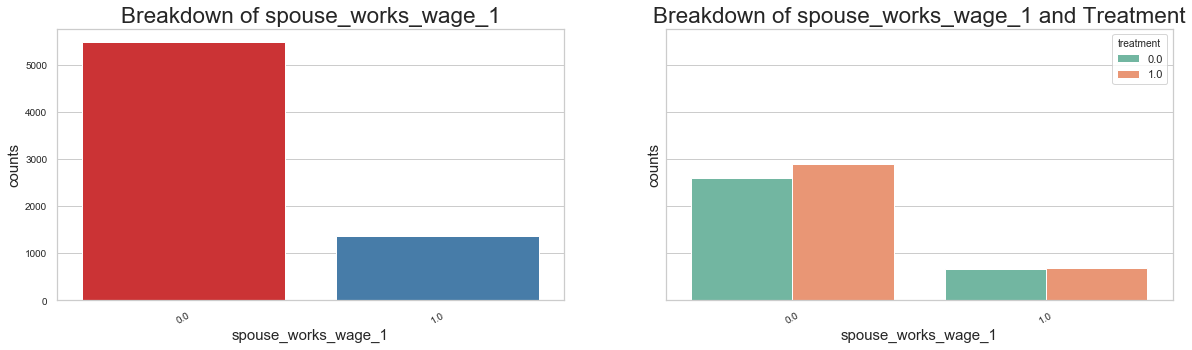

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,5))

plot_unit_distributions(df=df_full, variable='spouse_works_wage_1', treatment = None,
                        plot_x_label='spouse_works_wage_1', plot_y_label='counts', plot_title='Breakdown of spouse_works_wage_1', 
                        bins=None, figsize=None, fontsize=15, axis=ax1),

plot_unit_distributions(df=df_full, variable='spouse_works_wage_1', treatment = 'treatment',
                        plot_x_label='spouse_works_wage_1', plot_y_label='counts', plot_title='Breakdown of spouse_works_wage_1 and Treatment', 
                        bins=None, figsize=None, fontsize=15, axis=ax2)

Slight indication of self selection, as the women would be more likely to go for a loan if their spouse didn't work.

In [31]:
df.pivot_table(values=['biz_index_all_1', 'women_emp_index_1'],
               index='treatment',
               aggfunc=[np.mean],
               margins=True)

mean                  
          biz_index_all_1 women_emp_index_1
treatment                                  
0.0              0.106470         -0.007832
1.0              0.131328          0.004533
All              0.119309         -0.001445

## Modeling Data Preparation

In [32]:
# Counts for treatment
control_indexes = [i for i, e in enumerate(w) if e == 0]
treatment_indexes = [i for i, e in enumerate(w) if e == 1]

print(len(control_indexes))
print(len(treatment_indexes))

2576
2752


In [33]:
X_control = X[control_indexes]
y_control = y[control_indexes]
w_control = w[control_indexes]

X_treatment = X[treatment_indexes]
y_treatment = y[treatment_indexes]
w_treatment = w[treatment_indexes]

In [34]:
# Over-sampling of control
X_os, y_os, w_os = over_sample(X_1=X_control, y_1=y_control, w_1=w_control, 
                               sample_2_size=len(X_treatment), shuffle=True)


    Old Covariates shape  : (2576, 160)
    Old responses shape   : (2576,)
    Old treatments shape  : (2576,)
    New covariates shape  : (2752, 160)
    New responses shape   : (2752,)
    New treatments shape  : (2752,)
    Matched sample length :  2752
                        


In [35]:
X_split = np.append(X_os, X_treatment, axis=0)
y_split = np.append(y_os, y_treatment, axis=0)
w_split = np.append(w_os, w_treatment, axis=0)

X_split.shape, y_split.shape, w_split.shape # Should all be equal in the first dimension

((5504, 160), (5504,), (5504,))

In [36]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X_split, y_split, w_split, 
                                                                     percent_train=0.7, random_state=42, 
                                                                     maintain_proportions=True)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, w_train.shape, w_test.shape

((3852, 160), (1652, 160), (3852,), (1652,), (3852,), (1652,))

In [38]:
print(np.array(np.unique(w_train, return_counts=True)).T)
print(np.array(np.unique(w_test, return_counts=True)).T)

[[   0 1926]
 [   1 1926]]
[[  0 826]
 [  1 826]]


In [39]:
sn_ratio = signal_to_noise(y=y_split, w=w_split)
sn_ratio

0.2149301305377347

The signal to noise ratio suggests at a base level that there is a potential benefit to using CI with this dataset.

# Standard Models

The following cells present single iteration modeling, with analysis being done over multiple iterations.

## Two Model

In [40]:
tm = TwoModel(treatment_model=RandomForestRegressor(),
              control_model=RandomForestRegressor())
tm.fit(X=X_train, y=y_train, w=w_train)

In [44]:
tm_preds = tm.predict(X=X_test)
tm_preds[:5]

array([[0.07676931, 0.07755674],
       [0.15342537, 0.14812555],
       [0.347618  , 0.3773406 ],
       [1.29697517, 1.21813387],
       [0.        , 0.        ]])

## Interaction Term

In [45]:
it = InteractionTerm(model=RandomForestRegressor())
it.fit(X=X_train, y=y_train, w=w_train)

In [46]:
it_preds = it.predict(X=X_test)
it_preds[:5]

array([[0.07033577, 0.07257062],
       [0.15213514, 0.16819402],
       [0.37399592, 0.37578294],
       [1.35834111, 1.35721302],
       [0.        , 0.        ]])

## Class Transformations

Class transformation approaches aren't available for continuous response values yet. Work will be done to modify those algorithms to make them applicable in these settings.

# Evaluation

## Iterations

In [55]:
# For choosing the number of trees B at the order of N
num_trees = X_split.shape[0]
num_trees

5504

In [56]:
# New models istatiated with a more expansive scikit-learn base model
base_regression_model = RandomForestRegressor(n_estimators=200, 
                                              criterion='mse', 
                                              bootstrap=True)

tm = TwoModel(treatment_model=base_regression_model,
              control_model=base_regression_model)
it = InteractionTerm(model=base_regression_model)

In [57]:
n=10
model_eval_dict = {}
model_eval_dict['CMF Microfinance'] = {}
model_eval_dict

{'CMF Microfinance': {}}

In [59]:
for dataset in model_eval_dict.keys():
    for model in [tm, it]: #grf
        avg_preds, all_preds, \
        avg_eval, eval_variance, \
        eval_sd, all_evals = iterate_model(model=model, X_train=X_train, y_train=y_train, w_train=w_train,
                                            X_test=X_test, y_test=y_test, w_test=w_test, tau_test=None, n=10,
                                            pred_type='predict', eval_type='qini', 
                                            normalize_eval=False, notify_iter=n/10)
        model_eval_dict[dataset].update({str(model).split('.')[-1].split(' ')[0]: {'avg_preds': avg_preds, 'all_preds': all_preds, 
                                                                                   'avg_eval': avg_eval, 'eval_variance': eval_variance,
                                                                                   'eval_sd': eval_sd, 'all_evals': all_evals}})

Starting TwoModel iterations
20.0 percent of iterations have finished
40.0 percent of iterations have finished
60.0 percent of iterations have finished
80.0 percent of iterations have finished
100.0 percent of iterations have finished
-----
Starting InteractionTerm iterations
20.0 percent of iterations have finished
40.0 percent of iterations have finished
60.0 percent of iterations have finished
80.0 percent of iterations have finished
100.0 percent of iterations have finished
-----


In [60]:
# Treatment and control prediction subtraction
tm_effects = [model_eval_dict['CMF Microfinance']['TwoModel']['avg_preds'][i][0] \
              - model_eval_dict['CMF Microfinance']['TwoModel']['avg_preds'][i][1] \
              for i in range(len(model_eval_dict['CMF Microfinance']['TwoModel']['avg_preds']))]

# Treatment interaction and control interaction prediction subtraction
it_effects = [model_eval_dict['CMF Microfinance']['InteractionTerm']['avg_preds'][i][0] \
              - model_eval_dict['CMF Microfinance']['InteractionTerm']['avg_preds'][i][1] \
              for i in range(len(model_eval_dict['CMF Microfinance']['InteractionTerm']['avg_preds']))]

## Visual

In [61]:
visual_eval_dict = {'y_test': y_test, 'w_test': w_test, 
                    'two_model': tm_effects, 'interaction_term': it_effects}

In [62]:
df_visual_eval = pd.DataFrame(visual_eval_dict, columns = visual_eval_dict.keys())

display(df_visual_eval.head())
df_visual_eval.shape

,y_test,w_test,two_model,interaction_term
0,0.069684,1,0.0,-0.000788
1,0.129710,1,0.0,-0.009864
2,0.428351,1,0.0,0.000072
3,1.704667,1,0.0,0.010959
4,0.000000,1,0.0,0.000000


(1652, 4)

In [63]:
models = [col for col in visual_eval_dict.keys() if col not in ['y_test', 'w_test']]

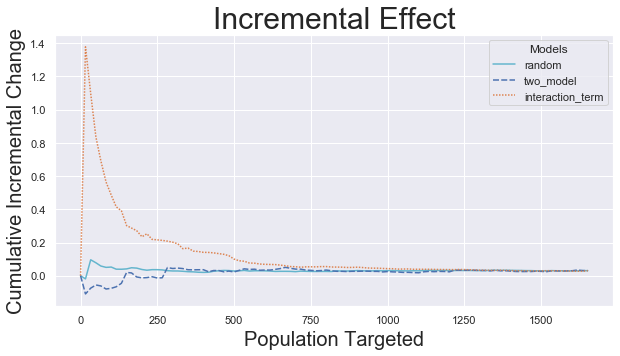

In [65]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20,5))

plot_cum_effect(df=df_visual_eval, n=100, models=models, percent_of_pop=False, 
                outcome_col='y_test', treatment_col='w_test', random_seed=42, 
                figsize=(10,5), fontsize=20, axis=None, legend_metrics=False)

# plot_batch_responses(df=df_visual_eval, n=10, models=models, 
#                      outcome_col='y_test', treatment_col='w_test', normalize=False,
#                      figsize=None, fontsize=15, axis=ax2)

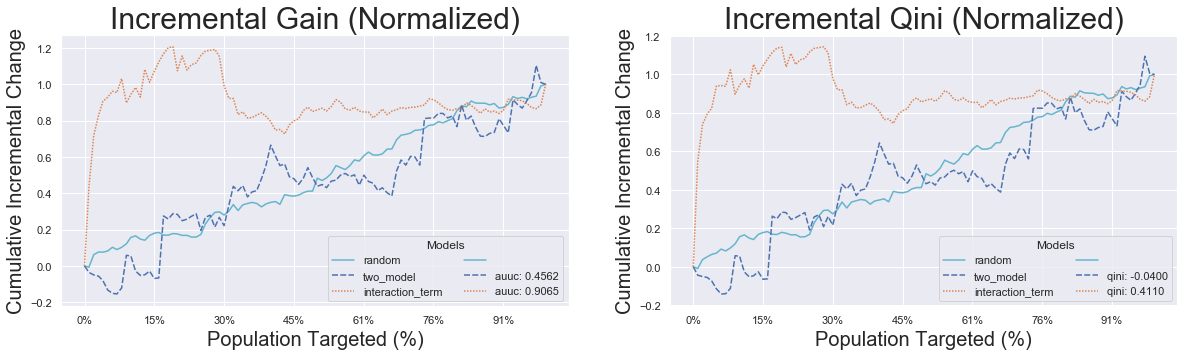

In [66]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20,5))

plot_cum_gain(df=df_visual_eval, n=100, models=models, percent_of_pop=True,
              outcome_col='y_test', treatment_col='w_test', normalize=True, random_seed=42, 
              figsize=None, fontsize=20, axis=ax1, legend_metrics=True)

plot_qini(df=df_visual_eval, n=100, models=models, percent_of_pop=True, 
          outcome_col='y_test', treatment_col='w_test', normalize=True, random_seed=42, 
          figsize=None, fontsize=20, axis=ax2, legend_metrics=True)

## Iterated Evaluation and Variance

In [68]:
# Qini
df_model_eval = eval_table(model_eval_dict, variances=True, annotate_vars=True)

df_model_eval

/Users/andrewmcallister/opt/anaconda3/lib/python3.7/site-packages/causeinfer/evaluation.py:1219: RuntimeWarning: invalid value encountered in double_scalars
  sds_to_0 = int(var/sd)


ValueError: cannot convert float NaN to integer

# Summary